### **資料前處理**

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# font
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 設定中文字型 - 微軟正黑體
plt.rcParams['axes.unicode_minus'] = False  # 解決負號'-'顯示為方塊的問題


In [21]:
# run on Kaggle
import os

# 列出 Kaggle input 目錄下的 dataset
os.listdir("/kaggle/input/winequality-white/")
df_white = pd.read_csv("/kaggle/input/winequality-white/winequality-white.csv", delimiter=";")
df_red = pd.read_csv("/kaggle/input/winequality-red/winequality-red.csv", delimiter=";")
# Pandas 預設將 ","當分隔符號，但特別是歐洲的 CSV 檔案，會用 ";"來區分欄位，要手動指定 delimiter=";"


#### **winequality-white**

In [22]:
print(f"Nan counts: {df_white.info()}")  # dtype and Nan
print("\n")
print(f"Data statistic:\n{df_white.describe()}")  # statistic
print("\n")

print(f"Data:\n{df_white.head()}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB
Nan counts: None


Data statistic:
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    4898.000000

#### **winequality-red**

In [23]:
print(f"Nan counts: {df_red.info()}")  # dtype and Nan
print("\n")
print(f"Data statistic:\n{df_red.describe()}")  # statistic
print("\n")

print(f"Data:\n{df_white.head()}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
Nan counts: None


Data statistic:
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000

#### **Combine Dataset**

In [24]:
df_white['type'] = 1
df_red['type'] = 0
df = pd.concat([df_white, df_red], axis=0, ignore_index=True)
print(df['type'].value_counts())
print("\n")
print(f"All columns(index):\n{df.columns}")


type
1    4898
0    1599
Name: count, dtype: int64


All columns(index):
Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'type'],
      dtype='object')


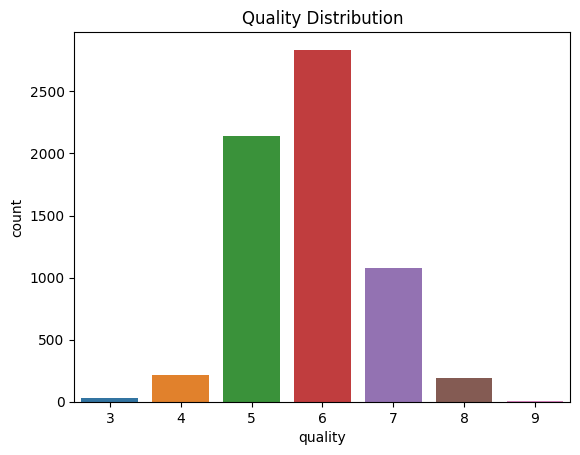

In [25]:
# Quality Distribution
sns.countplot(x=df['quality'])
plt.title("Quality Distribution")
plt.show()


#### **Labeling or One-Hot Encoding?**

- **要比較不同分類器的效果(LDA、QDA、Logistic Regression、K-NN)**，這些方法主要針對**二元分類**，所以**用 0/1  Labeling**
- 將品質評分轉換為**二元分類**（品質 >= 6 視為 "好酒"，品質 < 6 為 "壞酒"）


| 方法 | 影響 | 優勢 | 劣勢 |
|------|------|------|------|
| **One-Hot Encoding (多類別分類)** | **將 `quality` 分成 7 類別** | 能夠完整保留 `quality` 的細節 | 訓練更難、可能會有數據不均衡問題 |
| **Binary Labeling (0/1)** | **只區分「好酒」或「壞酒」** | 訓練較簡單，適合二元分類模型 | 無法區分中間品質的細節 |

1. **目標是區分「好酒 vs 壞酒」→ 二元分類（Binary Labeling）。**
2. **要預測 `quality` 的具體分數（3~9）→ One-Hot Encoding 或使用 Regression Model。**



In [26]:
# Labeling - .astype(int) -> int
df['label'] = (df['quality'] >= 6) # booling
df['label'] = df['label'].astype(int) # int
print(f"label:\n{df['label']}")


label:
0       1
1       1
2       1
3       1
4       1
       ..
6492    0
6493    1
6494    1
6495    0
6496    1
Name: label, Length: 6497, dtype: int64


#### **Normalization**

- **為何要標準化 features？**
標準化（Standardization）是針對 **數值型特徵（continuous features）**，主要是：
1. **讓不同量級的特徵有相同的影響力**  
   - `residual sugar` 可能範圍是 `0-50`，而 `pH` 可能是 `3-4`，如果**不標準化，較大的數值範圍會主導模型學習**。
   
2. **對於某些分類器（如 K-NN, Logistic Regression, LDA）效果更好**  
   - 這些模型對數值尺度敏感，因此標準化可以**提升分類效果**
     
3. **避免梯度下降時數值不穩定**（特別是在使用 Logistic Regression 時）
   - 若**不標準化，模型可能更難收斂，導致學習效果變差**。

In [27]:
X = df.drop(columns=['label','quality'])
y = df['label']

# feature Standardization
X_scaled = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=2024)
print(f"X_scaled:\n{X_scaled}")


X_scaled:
[[-0.16608919 -0.42318303  0.28468605 ... -0.54617826 -1.41855821
   0.57136659]
 [-0.70607349 -0.24094936  0.14704613 ... -0.27735097 -0.83161516
   0.57136659]
 [ 0.68245757 -0.36243847  0.55996589 ... -0.61338508 -0.32852111
   0.57136659]
 ...
 [-0.70607349  1.03468634 -1.29817304 ...  1.47002637  0.42611996
  -1.75018984]
 [-1.01463595  1.85473786 -1.366993   ...  1.20119908 -0.2446721
  -1.75018984]
 [-0.93749534 -0.1802048   1.04170561 ...  0.86516498  0.42611996
  -1.75018984]]


### **計算特徵相關性**

- 目標：檢查特徵之間的相關性，而不是直接分析 label 與 feature 之間的關聯。
- 如果**發現哪些特徵彼此之間有高度相關性，從而考慮降維或刪除**
- label 與 feature 之間的關聯通常會在**模型訓練過程中被捕捉**。


**比較：**

1. 協方差矩陣 (Covariance Matrix):
    - 衡量的是多個隨機變數之間「共同變化」的程度。
    - 矩陣中的元素是各對變數之間的協方差值。
    - 協方差的值受到變數尺度（單位）的影響。
2. 相關性矩陣 (Correlation Matrix):
    - 衡量的是多個隨機變數之間「線性關係」的強度和方向。
    - 矩陣中的元素是各對變數之間的相關係數（通常是皮爾森相關係數）。
    - 相關係數的值已被標準化，範圍在 -1 到 +1 之間，不受變數尺度的影響。

In [28]:
# Pearson Correlation Coefficient - df.corr()
corr_matrix = pd.DataFrame(X, columns=df.drop(columns=['label','quality','type']).columns).corr()
# print(corr_matrix['type'].sort_values(ascending=False))
# 'type' 只是拿來觀察不同酒類的成分關聯性，應刪除，因為非物理化學特徵


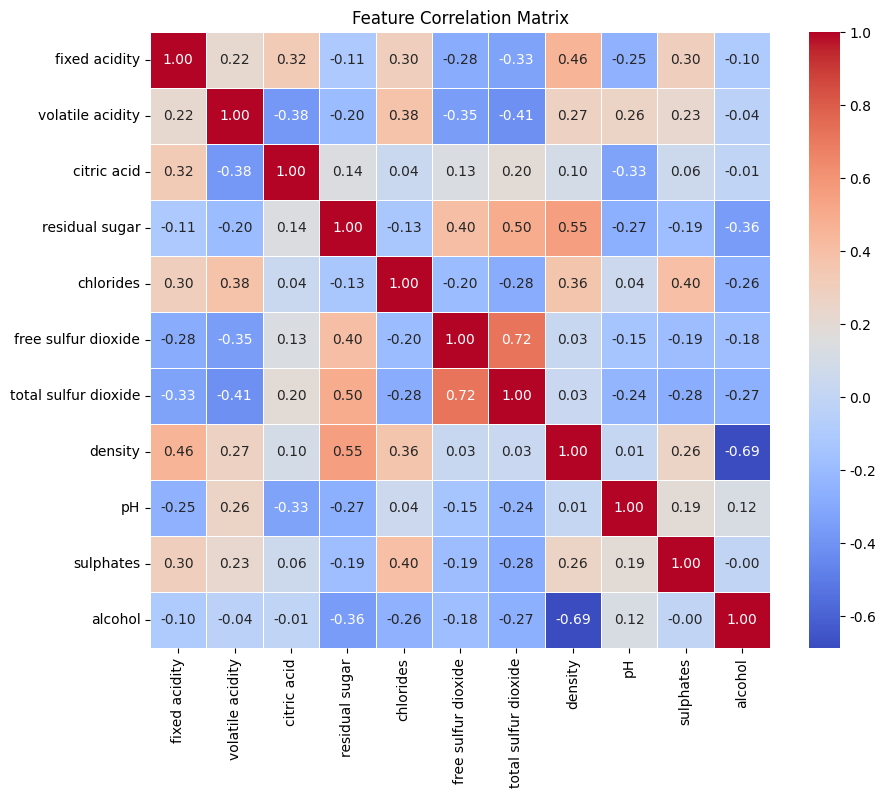

In [29]:
# Pearson Correlation Coefficient Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()


### **定義 Class Model 與 Cross-Val**

1. **Logistic Regression**：適合處理線性可分的資料。
2. **線性判別分析 LDA（Linear Discriminant Analysis）**：假設資料呈高斯分佈，且各類別的協方差矩陣相同。
3. **二次判別分析 QDA（Quadratic Discriminant Analysis）**：假設資料呈高斯分佈，但各類別的協方差矩陣可以不同。
4. **K-NN（K-Nearest Neighbors）**：一種非線性模型，基於樣本之間的距離進行分類，對資料分佈沒有特定假設，很適合處理較複雜的分類問題。
  

In [30]:
# K(cv)
cv = KFold(n_splits=5, shuffle=True, random_state=2042)

classifiers = {
    "Logistic Regression": LogisticRegression(),
    "LDA": LDA(),
    "QDA": QDA(),
    "K-NN (k=5)": KNeighborsClassifier(n_neighbors=5)
}

results = {}

# training / evaluation
for name, model in classifiers.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    results[name] = {
        "Mean Accuracy": np.mean(scores),
        "Std Accuracy": np.std(scores)
    }
    print(f"{name:<20} Mean Accuracy = {np.mean(scores):.4f} | Std Accuracy = {np.std(scores):.4f}")


Logistic Regression  Mean Accuracy = 0.7448 | Std Accuracy = 0.0176
LDA                  Mean Accuracy = 0.7437 | Std Accuracy = 0.0167
QDA                  Mean Accuracy = 0.7383 | Std Accuracy = 0.0169
K-NN (k=5)           Mean Accuracy = 0.7570 | Std Accuracy = 0.0096


#### **小結論**

* **K-NN (k=5) 表現最佳：**
    * K-NN (k=5) 在所有模型中具有最高的平均準確度 (Mean Accuracy = 0.7570)，這表示它在預測能力上略優於其他模型。
    * 此外，它的標準差 (Std = 0.0096) 也是最小的，這意味著其預測結果的穩定性最高，變異性最小，可靠性最高。
* **Logistic Regression 與 LDA 性能相近：**
    * Logistic Regression 和 LDA 的平均準確度非常接近，分別為 0.7448 和 0.7437。
    * 它們的標準差也相當接近，表明它們的預測穩定性也相似。
* **QDA 表現略遜，在此數據集中，預測效果並沒有前三個模型好。：**
    - QDA 需要更多的資料來學習，如果資料不夠，效能不會展現出來
    * 平均準確度最低 (0.7383)，表明其預測性能略低於其他模型。
    * 標準差與 Logistic Regression 與 LDA 相近，穩定度相似。

### **初步模型訓練與評估**

- 目標：
  1. 訓練模型
  2. 計算 Accuracy、Precision、Recall、F1 Score
  3. 繪製混淆矩陣

**混淆矩陣（Confusion Matrix）**
- 一個用於評估分類模型效能的工具，特別是在**二元分類問題中非常有用**。在某些應用場景中，準確度可能不是評估模型效能的最佳指標，特別是在資料集不平衡（即正例和負例樣本數量差異很大）的情況下，混淆矩陣能提供更全面的評估，幫助了解模型在不同類別上的表現，從而做出更明智的決策。它以表格的形式呈現模型的預測結果與實際結果之間的差異，幫助更深入地了解模型的表現。

- 對於二元分類問題，混淆矩陣通常是一個 2x2 的表格，包含以下四個元素：
1. **True Positive (TP)**：模型正確地預測為正例的樣本數。
2. **True Negative (TN)**：模型正確地預測為負例的樣本數。
3. **False Positive (FP)**：模型錯誤地預測為正例的樣本數，也稱為 Type I Error（第一型錯誤）。
4. **False Negative (FN)**：模型錯誤地預測為負例的樣本數，也稱為 Type II Error（第二型錯誤）。


- 不僅能夠幫助了解模型預測正確的比例（準確度），還能提供更詳細的分類結果分析
1.  **精確率（Precision）**：模型預測為正例的樣本中，實際為正例的比例。
2.  **召回率（Recall）**：實際為正例的樣本中，模型成功預測為正例的比例。
3.  **F1 分數（F1-score）**：精確率和召回率的調和平均數，用於綜合評估模型的性能。
   

In [31]:
# training / evaluation
evaluation_metrics = {}

for name, model in classifiers.items():
    model.fit(X_train, y_train) # 只是想評估模型在特定測試資料集上效能的話，則不需要使用 Cross-validate() 進行泛化跟預測
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    evaluation_metrics[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    }

    print(f"\n{name}:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall: {rec:.4f}")
    print(f"  F1 Score: {f1:.4f}")



Logistic Regression:
  Accuracy: 0.7400
  Precision: 0.7698
  Recall: 0.8392
  F1 Score: 0.8030

LDA:
  Accuracy: 0.7400
  Precision: 0.7698
  Recall: 0.8392
  F1 Score: 0.8030

QDA:
  Accuracy: 0.7146
  Precision: 0.7451
  Recall: 0.8331
  F1 Score: 0.7867

K-NN (k=5):
  Accuracy: 0.7500
  Precision: 0.7838
  Recall: 0.8343
  F1 Score: 0.8083


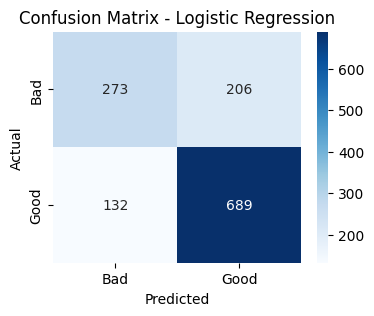

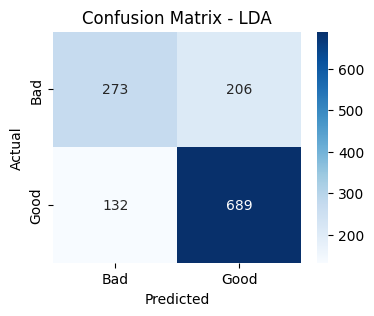

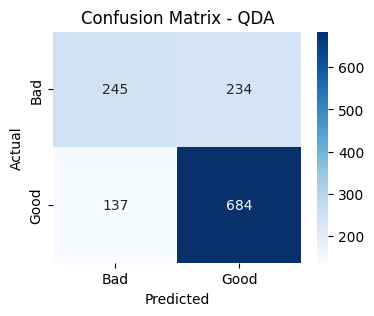

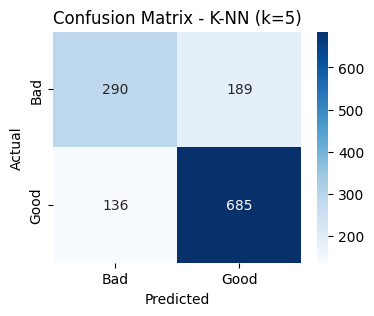

In [32]:
# Confusion Matrix
for name, model in classifiers.items():
    model.fit(X_train, y_train) # 只是想評估模型在特定測試資料集上效能的話，則不需要使用 Cross-validate()進行泛化跟預測
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=["Bad", "Good"], yticklabels=["Bad", "Good"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


#### **小結論**

- 因為白酒資料量為紅酒的 3 倍，**資料不平衡很可能影響了模型的 Accuracy -> 模型可能偏向預測佔多數的類別（白酒）**。
- 在評估模型時，應該更重視 precision、recall 和 F1。
- Logistic Regression 和 LDA 在數據上學習到了非常類似的決策邊界，可能是因為**數據的分佈較適合線性分類方法**。
- QDA **允許非線性邊界**，但如果數據實際上是線性可分，那麼可能會 Overfitting 或學習到不理想的決策邊界。
  
| **模型** | **適用情境** | **優勢** | **劣勢** |
|----------|------------|--------|--------|
| **K-NN（k=5）** | 追求最佳分類表現 | 最高 Accuracy & F1 Score | 計算量較大，不適合大數據 |
| **LDA / Logistic Regression** | 需要高效、可解釋的模型 | 較輕量、結果相同 | 精度略低於 K-NN |
| **QDA** | 若數據具明顯非線性分佈 | 適合非線性決策邊界 | 表現較差 |

### **將 Type 從 X 移除（因為白酒與紅酒資料不平衡）**

In [33]:
X = df.drop(columns=['label','quality','type'])
y = df['label']

# feature Standardization
X_scaled = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=2024)

# training / evaluation
evaluation_metrics = {}

for name, model in classifiers.items():
    model.fit(X_train, y_train) # 只是想評估模型在特定測試資料集上效能的話，則不需要使用 Cross-validate()進行泛化跟預測
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    evaluation_metrics[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    }

    print(f"\n{name}:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall: {rec:.4f}")
    print(f"  F1 Score: {f1:.4f}")



Logistic Regression:
  Accuracy: 0.7415
  Precision: 0.7716
  Recall: 0.8392
  F1 Score: 0.8040

LDA:
  Accuracy: 0.7423
  Precision: 0.7724
  Recall: 0.8392
  F1 Score: 0.8044

QDA:
  Accuracy: 0.7162
  Precision: 0.7441
  Recall: 0.8392
  F1 Score: 0.7888

K-NN (k=5):
  Accuracy: 0.7492
  Precision: 0.7829
  Recall: 0.8343
  F1 Score: 0.8078


#### **小結論**

**🔹 變更前後結果比較**
| **模型** | **移除 `type` 前 - Accuracy** | **移除 `type` 後 - Accuracy** | **變化** |
|----------|-------------------|-------------------|--------|
| **Logistic Regression** | 0.7400 | 0.7415 | **+0.0015** |
| **LDA** | 0.7400 | 0.7423 | **+0.0023** |
| **QDA** | 0.7146 | 0.7162 | **+0.0016** |
| **K-NN (k=5)** | 0.7500 | 0.7492 | **-0.0008** |

| **模型** | **移除 `type` 前 - F1 Score** | **移除 `type` 後 - F1 Score** | **變化** |
|----------|-------------------|-------------------|--------|
| **Logistic Regression** | 0.8030 | 0.8040 | **+0.0010** |
| **LDA** | 0.8030 | 0.8044 | **+0.0014** |
| **QDA** | 0.7867 | 0.7888 | **+0.0021** |
| **K-NN (k=5)** | 0.8083 | 0.8078 | **-0.0005** |


**1. 大部分模型的表現略有提升（特別是 LDA、QDA）**
   - **LDA 的 Accuracy +0.23%，F1 Score +0.14%**
   - **QDA 的 Accuracy +0.16%，F1 Score +0.21%**

**2. K-NN 表現幾乎不變，甚至稍微下降**
   - **Accuracy 下降 0.08%，F1 Score 下降 0.05%**，這表示 K-NN 可能更依賴 `type` 作為分類特徵。
   - 由於 K-NN 是基於鄰近點的距離來進行分類，`type` 提供了「紅酒 vs. 白酒」的額外區分資訊，移除後影響較其他模型更明顯。

**3. 移除 `type` 整體提升了分類器的泛化能力**
- **LDA、Logistic Regression、QDA 都有所改善**，表示 `type` 可能是個「**捷徑特徵（Shortcut Feature）**」使得模型過度依賴葡萄酒的類別，而非根據化學特性進行分類。

**4. 移除 `type` 之後，結果變得更可靠，更能反映酒的內在特徵。**


### **K-NN 選擇最佳 K 值**

- 目標：找到最佳的 K 值，使 K-NN 模型的準確度最大化

**如何選擇最佳 K 值？**

1. 若 Precision、Recall 差距大：
- **Precision 高但 Recall 低 → 代表模型過於保守，應該降低 K 值，讓模型更敏感。**
- **Recall 高但 Precision 低 → 代表模型容易誤判，應該增加 K 值，使模型更穩定。**
      
2. **選擇 F1 Score 最佳的 K 值**
- F1 Score 平衡了 Precision 和 Recall，**如果某個 K 值的 F1 Score 明顯較高，通常是最好的選擇。**

     K  Accuracy  Precision  Recall  F1 Score
0    1     0.766      0.812   0.821     0.816
1    2     0.715      0.848   0.670     0.749
2    3     0.749      0.790   0.822     0.805
3    4     0.746      0.828   0.756     0.791
4    5     0.758      0.789   0.843     0.815
5    6     0.757      0.820   0.789     0.804
6    7     0.758      0.788   0.845     0.816
7    8     0.757      0.809   0.807     0.808
8    9     0.759      0.786   0.851     0.817
9   10     0.756      0.803   0.815     0.809
10  11     0.756      0.783   0.850     0.815
11  12     0.757      0.800   0.822     0.811
12  13     0.752      0.779   0.849     0.813
13  14     0.757      0.799   0.823     0.811
14  15     0.756      0.782   0.853     0.816
15  16     0.755      0.793   0.829     0.811
16  17     0.754      0.779   0.854     0.815
17  18     0.755      0.791   0.834     0.812
18  19     0.751      0.775   0.854     0.813
19  20     0.752      0.786   0.835     0.810


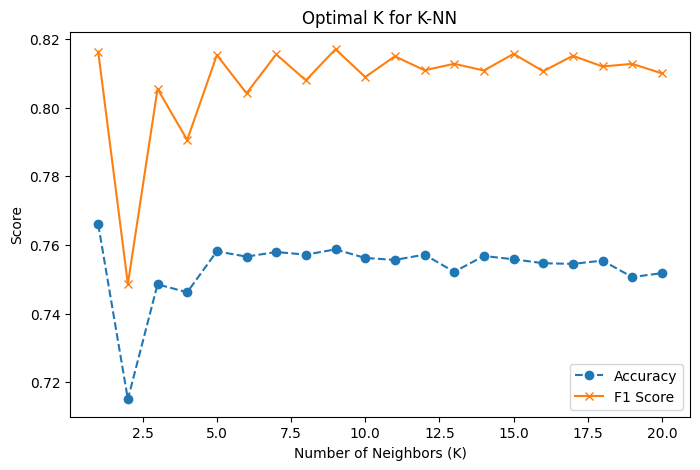

In [40]:
k_values = range(1, 21)
knn_accuracies =[]
knn_f1s = []
results = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    y_pred = cross_val_predict(knn, X_train, y_train, cv=cv)

    acc = accuracy_score(y_train, y_pred)
    prec = precision_score(y_train, y_pred)
    rec = recall_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)

    results.append((k, round(acc, 3), round(prec, 3), round(rec, 3), round(f1, 3)))
    knn_accuracies.append(acc)
    knn_f1s.append(f1)

results_df = pd.DataFrame(results, columns=['K', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
print(results_df)

# Optimal K for K-NN
plt.figure(figsize=(8, 5))
plt.plot(k_values, knn_accuracies, marker='o', linestyle='dashed', label='Accuracy')
plt.plot(k_values, knn_f1s, marker='x', linestyle='solid', label='F1 Score')
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Score")
plt.legend()
plt.title("Optimal K for K-NN")
plt.show()


#### **Result**

**1. K=1 的 Accuracy 最高，但可能 Overfitting**，K 值太小模型過度依賴鄰近的單一數據點，導致泛化能力下降，通常不會選擇作為最終模型，**應避免 K=1 或 K=2**。

**2. K=7, K=9 是最佳的選擇：**
- 從 Accuracy 和 F1 Score 綜合考量，**K=7、K=9** 表現良好，**F1 Score 最高 (0.816, 0.817)**，代表 Precision 和 Recall 維持最佳平衡；**Accuracy 也很高 (0.758, 0.759)** 泛化能力較佳：

- **K=7**:
  - Accuracy = 0.758
  - Precision = 0.788
  - Recall = 0.845
  - F1 Score = 0.816
- **K=9**:
  - Accuracy = 0.759
  - Precision = 0.786
  - Recall = 0.851
  - F1 Score = 0.817

**3. K > 10 後模型表現穩定**
從 K=10 開始，Accuracy 約落在 **0.752~0.757**，F1 Score 約 **0.810~0.815**，變動不大：
- **K=15~K=20** 的 Accuracy 幾乎沒有顯著提升。
- **Recall 在 K > 15 後保持在 0.83~0.85**，但 Precision 稍微下降。
- **較大的 K 值（15 以上）模型已經趨於平穩，沒有顯著提升表現**，反而可能過度平滑，使模型對少數類別的區分能力下降。

**4. 最理想的是 Precision 和 Recall 平衡，避免過度偏向其中之一：**
- **Precision 較高的 K 值**（K=1, 5, 7, 10），代表模型較謹慎，避免誤判「好酒」。
- **Recall 較高的 K 值**（K=9, 11, 17），代表模型能夠找到更多「好酒」，但可能會有較多誤判。